# **YOLO NAS: Training and Testing**



# **Section 01.** Necessary Setup and Imports

In [2]:
# Connect with personal Drive account
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir(r'/content/drive/MyDrive/TIC-YOLO')

In [4]:
# One time installation.
!pip install super-gradients==3.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 60.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 12.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to

### Obs: Restart section after installation "super-gradients" if running on Colab

In [1]:
# It is required to install "supervision"
import locale

In [2]:
# It is required to install "supervision"
locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
pip install supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 5.0 MB/s eta 0:00:00


In [4]:
import supervision as sv

In [5]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
# Metrics to evaluate the model
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_075,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

[2024-07-21 18:05:18] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-07-21 18:05:22] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-07-21 18:05:27] INFO - utils.py - NumExpr defaulting to 2 threads.
[2024-07-21 18:05:29] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-07-21 18:05:29] WARNING - export.py - Failed to import pytorch_quantization
[2024-07-21 18:05:29] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


# **Section 02.** Dataset Set Up

In [6]:
# We set file paths and fix the classes
ROOT_DIR = '/content/drive/MyDrive/TIC-YOLO/ColdwaterML'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['Car', 'Pickup truck', 'Truck','Bus']

In [7]:
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'test_images_dir':test_imgs_dir,
    'test_labels_dir':test_labels_dir,
    'classes':classes
}

In [8]:
# Global hiperparameters
EPOCHS = 10
BATCH_SIZE = 16
WORKERS = 3

# **Section 03.** Visualize Ground Truth Images (Real Annotations)

In [9]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [10]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [11]:
# Function to plot an image with its bounding boxes
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=lw,
            lineType=cv2.LINE_AA
        )

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name,
            0,
            fontScale=lw / 3,
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=-1,
            lineType=cv2.LINE_AA
        )
        cv2.putText(
            image,
            class_name,
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=lw/3.5,
            color=(255, 255, 255),
            thickness=tf,
            lineType=cv2.LINE_AA
        )
    return image

In [12]:
# Function to plot a set of images with their bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()

    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)

    num_images = len(all_training_images)

    if num_samples == -1:
        num_samples = num_images

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(int(float(label)))
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [13]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir),
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=4,
)

Output hidden; open in https://colab.research.google.com to view.

# **Section 04.** Data Preparation

### **Section 04.01.** Converting Train, Val and Test Data in YOLO format

In [15]:
import collections
collections.Iterable = collections.abc.Iterable

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 1,
        'num_workers': WORKERS
    }
)

[2024-07-21 18:24:37] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 825/825 [00:06<00:00, 124.53it/s]
[2024-07-21 18:24:44] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 165/165 [00:01<00:00, 138.82it/s]
[2024-07-21 18:24:45] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 165/165 [00:01<00:00, 140.59it/s]


### **Section 04.02.** Creation of a data.yaml File (run this if it is necessary only)

In [16]:
'''
import yaml
data_yaml_content = {
    'train': '/content/drive/MyDrive/TIC-YOLO/ColdwaterML/images/train',
    'val': '/content/drive/MyDrive/TIC-YOLO/ColdwaterML/images/val',
    'test': '/content/drive/MyDrive/TIC-YOLO/ColdwaterML/images/test',
    'nc': 4,
    'names': ['Car', 'Pickup truck', 'Truck', 'Bus']
}

# We define the path were the file is going to be kept
data_yaml_path = "/content/drive/MyDrive/TIC-YOLO/ColdwaterML/data.yaml"

# Writing the content in the .yaml file
with open(data_yaml_path, "w") as file:
    yaml.dump(data_yaml_content, file)

print(f"File data.yaml created at {data_yaml_path}")
'''

'\nimport yaml\ndata_yaml_content = {\n    \'train\': \'/content/drive/MyDrive/TIC-YOLO/ColdwaterML/images/train\',\n    \'val\': \'/content/drive/MyDrive/TIC-YOLO/ColdwaterML/images/val\',\n    \'test\': \'/content/drive/MyDrive/TIC-YOLO/ColdwaterML/images/test\',\n    \'nc\': 4,\n    \'names\': [\'Car\', \'Pickup truck\', \'Truck\', \'Bus\']\n}\n\n# We define the path were the file is going to be kept\ndata_yaml_path = "/content/drive/MyDrive/TIC-YOLO/ColdwaterML/data.yaml"\n\n# Writing the content in the .yaml file\nwith open(data_yaml_path, "w") as file:\n    yaml.dump(data_yaml_content, file)\n\nprint(f"File data.yaml created at {data_yaml_path}")\n'

### **Section 04.03.** Data Augmentation

In [17]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [18]:
train_data.dataset.transforms[0]

DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114)

In [19]:
# An example on how to modify augmentations
train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

In [20]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_empty_targets': False, 'swap': (2, 0, 1), 'input_dim': (640, 640), 'pad_value': 114),
 DetectionTargetsFormatTransform('additional_samples_count': 0, 'non_empty_targets': False, 'input_format': OrderedDi

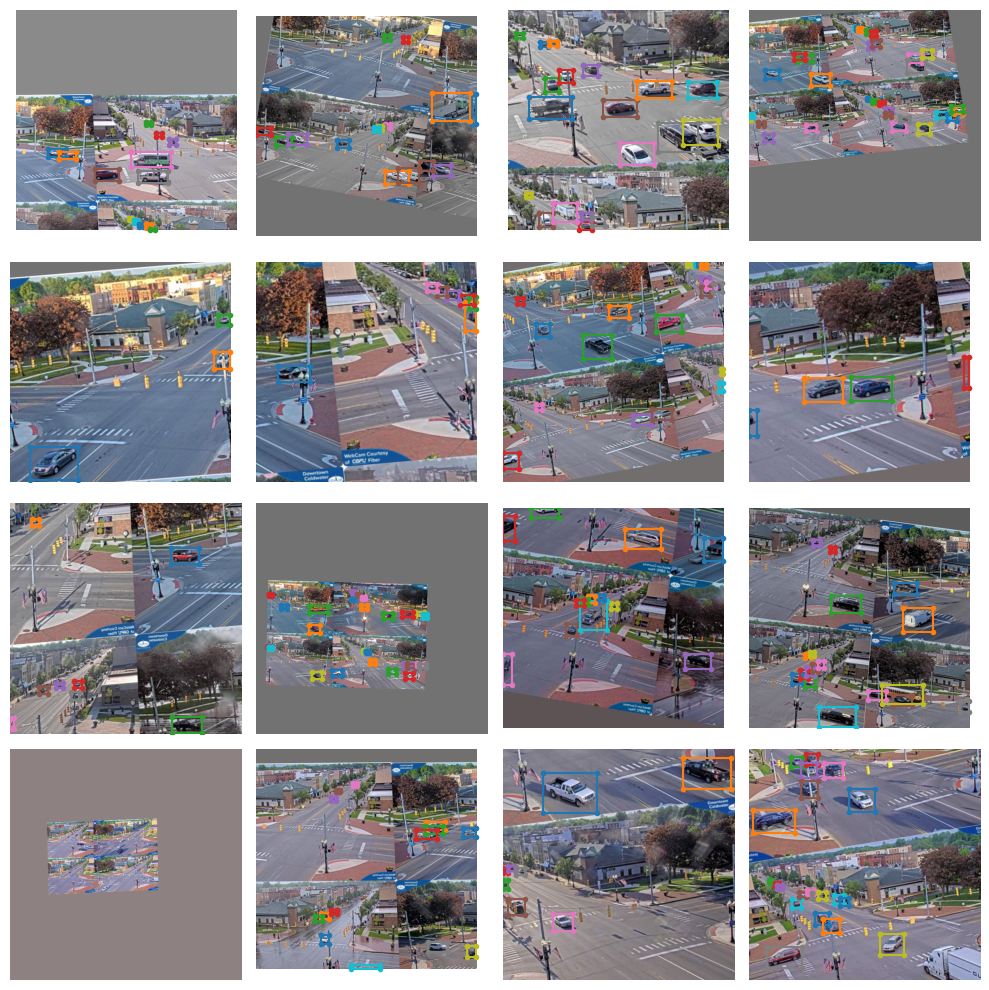

In [21]:
# We visualize the images with augmentation here.
train_data.dataset.plot(plot_transformed_data=True)

# **Section 05.** Setting up Training Parameters

In [22]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_075(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [23]:
models_to_train = [
    'yolo_nas_s',
    # 'yolo_nas_m',
    # 'yolo_nas_l'
]

In [24]:
# Create the the folder were we want to keep the model results
CHECKPOINT_DIR = 'checkpoints'

# **Section 06.** Model Training

In [25]:
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train,
        ckpt_root_dir=CHECKPOINT_DIR
    )

    model = models.get(
        model_to_train,
        num_classes=len(dataset_params['classes']),
        pretrained_weights="coco"
    )

    trainer.train(
        model=model,
        training_params=train_params,
        train_loader=train_data,
        valid_loader=val_data
    )

[2024-07-21 18:25:49] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:05<00:00, 13.6MB/s]
[2024-07-21 18:25:56] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


The console stream is now moved to checkpoints/yolo_nas_s/console_Jul21_18_25_57.txt


[2024-07-21 18:25:57] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2024-07-21 18:26:08] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 825        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         51         (len(train_loader))
    - Gradient updates per epoch:   51         (len(train_loader) / batch_accumulate)

[2024-07-21 18:26:08] INFO - sg_trainer.py - Started training for 10 epochs (0/9)

Validating: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]
[2024-07-21 18:27:45] INFO - base_sg_logger.py -

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.3313
│   ├── Ppyoloeloss/loss_iou = 0.2904
│   ├── Ppyoloeloss/loss_dfl = 1.038
│   └── Ppyoloeloss/loss = 3.5764
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.515
    ├── Ppyoloeloss/loss_iou = 0.2147
    ├── Ppyoloeloss/loss_dfl = 0.7308
    ├── Ppyoloeloss/loss = 3.4173
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0073
    ├── F1@0.50 = 0.0
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50:0.95 = 0.0
    ├── Map@0.50:0.95 = 0.005
    ├── F1@0.50:0.95 = 0.0
    ├── Precision@0.75 = 0.0
    ├── Recall@0.75 = 0.0
    ├── Map@0.75 = 0.0056
    └── F1@0.75 = 0.0



Validating epoch 1: 100%|██████████| 11/11 [00:11<00:00,  1.08s/it]
[2024-07-21 18:29:22] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2024-07-21 18:29:22] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1969141960144043


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0576
│   │   ├── Epoch N-1      = 2.3313 (↘ -1.2736)
│   │   └── Best until now = 2.3313 (↘ -1.2736)
│   ├── Ppyoloeloss/loss_iou = 0.2044
│   │   ├── Epoch N-1      = 0.2904 (↘ -0.0861)
│   │   └── Best until now = 0.2904 (↘ -0.0861)
│   ├── Ppyoloeloss/loss_dfl = 0.7238
│   │   ├── Epoch N-1      = 1.038  (↘ -0.3143)
│   │   └── Best until now = 1.038  (↘ -0.3143)
│   └── Ppyoloeloss/loss = 1.9304
│       ├── Epoch N-1      = 3.5764 (↘ -1.646)
│       └── Best until now = 3.5764 (↘ -1.646)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2955
    │   ├── Epoch N-1      = 2.515  (↘ -1.2195)
    │   └── Best until now = 2.515  (↘ -1.2195)
    ├── Ppyoloeloss/loss_iou = 0.1887
    │   ├── Epoch N-1      = 0.2147 (↘ -0.026)
    │   └── Best until now = 0.2147 (↘ -0.026)
    ├── Ppyoloeloss/loss_dfl = 0.7176
    │   ├── Epoch N-1      = 0.7308 (↘ -0.0133)
    │   └── Best until now = 0.7308 (↘ -0.0133)
    ├── Ppyoloeloss/loss =

Validating epoch 2: 100%|██████████| 11/11 [00:09<00:00,  1.22it/s]
[2024-07-21 18:31:00] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2024-07-21 18:31:00] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3150669038295746


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8412
│   │   ├── Epoch N-1      = 1.0576 (↘ -0.2164)
│   │   └── Best until now = 1.0576 (↘ -0.2164)
│   ├── Ppyoloeloss/loss_iou = 0.1751
│   │   ├── Epoch N-1      = 0.2044 (↘ -0.0292)
│   │   └── Best until now = 0.2044 (↘ -0.0292)
│   ├── Ppyoloeloss/loss_dfl = 0.6836
│   │   ├── Epoch N-1      = 0.7238 (↘ -0.0402)
│   │   └── Best until now = 0.7238 (↘ -0.0402)
│   └── Ppyoloeloss/loss = 1.6208
│       ├── Epoch N-1      = 1.9304 (↘ -0.3096)
│       └── Best until now = 1.9304 (↘ -0.3096)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8513
    │   ├── Epoch N-1      = 1.2955 (↘ -0.4442)
    │   └── Best until now = 1.2955 (↘ -0.4442)
    ├── Ppyoloeloss/loss_iou = 0.1813
    │   ├── Epoch N-1      = 0.1887 (↘ -0.0074)
    │   └── Best until now = 0.1887 (↘ -0.0074)
    ├── Ppyoloeloss/loss_dfl = 0.686
    │   ├── Epoch N-1      = 0.7176 (↘ -0.0315)
    │   └── Best until now = 0.7176 (↘ -0.0315)
    ├── Ppyoloeloss/los

Validating epoch 3: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]
[2024-07-21 18:32:38] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2024-07-21 18:32:38] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.37033340334892273


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8163
│   │   ├── Epoch N-1      = 0.8412 (↘ -0.0249)
│   │   └── Best until now = 0.8412 (↘ -0.0249)
│   ├── Ppyoloeloss/loss_iou = 0.1703
│   │   ├── Epoch N-1      = 0.1751 (↘ -0.0048)
│   │   └── Best until now = 0.1751 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_dfl = 0.6755
│   │   ├── Epoch N-1      = 0.6836 (↘ -0.008)
│   │   └── Best until now = 0.6836 (↘ -0.008)
│   └── Ppyoloeloss/loss = 1.5799
│       ├── Epoch N-1      = 1.6208 (↘ -0.0409)
│       └── Best until now = 1.6208 (↘ -0.0409)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8224
    │   ├── Epoch N-1      = 0.8513 (↘ -0.029)
    │   └── Best until now = 0.8513 (↘ -0.029)
    ├── Ppyoloeloss/loss_iou = 0.155
    │   ├── Epoch N-1      = 0.1813 (↘ -0.0264)
    │   └── Best until now = 0.1813 (↘ -0.0264)
    ├── Ppyoloeloss/loss_dfl = 0.6556
    │   ├── Epoch N-1      = 0.686  (↘ -0.0304)
    │   └── Best until now = 0.686  (↘ -0.0304)
    ├── Ppyoloeloss/loss = 

Validating epoch 4: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]
[2024-07-21 18:34:15] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2024-07-21 18:34:15] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4096580147743225


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7891
│   │   ├── Epoch N-1      = 0.8163 (↘ -0.0271)
│   │   └── Best until now = 0.8163 (↘ -0.0271)
│   ├── Ppyoloeloss/loss_iou = 0.1648
│   │   ├── Epoch N-1      = 0.1703 (↘ -0.0056)
│   │   └── Best until now = 0.1703 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.6682
│   │   ├── Epoch N-1      = 0.6755 (↘ -0.0073)
│   │   └── Best until now = 0.6755 (↘ -0.0073)
│   └── Ppyoloeloss/loss = 1.5352
│       ├── Epoch N-1      = 1.5799 (↘ -0.0447)
│       └── Best until now = 1.5799 (↘ -0.0447)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.764
    │   ├── Epoch N-1      = 0.8224 (↘ -0.0584)
    │   └── Best until now = 0.8224 (↘ -0.0584)
    ├── Ppyoloeloss/loss_iou = 0.1648
    │   ├── Epoch N-1      = 0.155  (↗ 0.0098)
    │   └── Best until now = 0.155  (↗ 0.0098)
    ├── Ppyoloeloss/loss_dfl = 0.6653
    │   ├── Epoch N-1      = 0.6556 (↗ 0.0097)
    │   └── Best until now = 0.6556 (↗ 0.0097)
    ├── Ppyoloeloss/loss = 

Validating epoch 5: 100%|██████████| 11/11 [00:09<00:00,  1.20it/s]
[2024-07-21 18:36:01] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2024-07-21 18:36:01] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.43210500478744507


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7639
│   │   ├── Epoch N-1      = 0.7891 (↘ -0.0252)
│   │   └── Best until now = 0.7891 (↘ -0.0252)
│   ├── Ppyoloeloss/loss_iou = 0.1563
│   │   ├── Epoch N-1      = 0.1648 (↘ -0.0085)
│   │   └── Best until now = 0.1648 (↘ -0.0085)
│   ├── Ppyoloeloss/loss_dfl = 0.6559
│   │   ├── Epoch N-1      = 0.6682 (↘ -0.0123)
│   │   └── Best until now = 0.6682 (↘ -0.0123)
│   └── Ppyoloeloss/loss = 1.4826
│       ├── Epoch N-1      = 1.5352 (↘ -0.0526)
│       └── Best until now = 1.5352 (↘ -0.0526)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7638
    │   ├── Epoch N-1      = 0.764  (↘ -0.0002)
    │   └── Best until now = 0.764  (↘ -0.0002)
    ├── Ppyoloeloss/loss_iou = 0.1427
    │   ├── Epoch N-1      = 0.1648 (↘ -0.0221)
    │   └── Best until now = 0.155  (↘ -0.0123)
    ├── Ppyoloeloss/loss_dfl = 0.627
    │   ├── Epoch N-1      = 0.6653 (↘ -0.0383)
    │   └── Best until now = 0.6556 (↘ -0.0286)
    ├── Ppyoloeloss/los

Validating epoch 6: 100%|██████████| 11/11 [00:09<00:00,  1.20it/s]
[2024-07-21 18:37:47] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2024-07-21 18:37:47] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.46517708897590637


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7328
│   │   ├── Epoch N-1      = 0.7639 (↘ -0.0311)
│   │   └── Best until now = 0.7639 (↘ -0.0311)
│   ├── Ppyoloeloss/loss_iou = 0.1516
│   │   ├── Epoch N-1      = 0.1563 (↘ -0.0047)
│   │   └── Best until now = 0.1563 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_dfl = 0.6519
│   │   ├── Epoch N-1      = 0.6559 (↘ -0.004)
│   │   └── Best until now = 0.6559 (↘ -0.004)
│   └── Ppyoloeloss/loss = 1.4378
│       ├── Epoch N-1      = 1.4826 (↘ -0.0448)
│       └── Best until now = 1.4826 (↘ -0.0448)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7239
    │   ├── Epoch N-1      = 0.7638 (↘ -0.04)
    │   └── Best until now = 0.7638 (↘ -0.04)
    ├── Ppyoloeloss/loss_iou = 0.146
    │   ├── Epoch N-1      = 0.1427 (↗ 0.0034)
    │   └── Best until now = 0.1427 (↗ 0.0034)
    ├── Ppyoloeloss/loss_dfl = 0.6324
    │   ├── Epoch N-1      = 0.627  (↗ 0.0054)
    │   └── Best until now = 0.627  (↗ 0.0054)
    ├── Ppyoloeloss/loss = 1.4052

Validating epoch 7: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]
[2024-07-21 18:39:34] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2024-07-21 18:39:34] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.47596275806427


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7132
│   │   ├── Epoch N-1      = 0.7328 (↘ -0.0195)
│   │   └── Best until now = 0.7328 (↘ -0.0195)
│   ├── Ppyoloeloss/loss_iou = 0.1455
│   │   ├── Epoch N-1      = 0.1516 (↘ -0.0062)
│   │   └── Best until now = 0.1516 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.6414
│   │   ├── Epoch N-1      = 0.6519 (↘ -0.0105)
│   │   └── Best until now = 0.6519 (↘ -0.0105)
│   └── Ppyoloeloss/loss = 1.3976
│       ├── Epoch N-1      = 1.4378 (↘ -0.0403)
│       └── Best until now = 1.4378 (↘ -0.0403)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7142
    │   ├── Epoch N-1      = 0.7239 (↘ -0.0097)
    │   └── Best until now = 0.7239 (↘ -0.0097)
    ├── Ppyoloeloss/loss_iou = 0.157
    │   ├── Epoch N-1      = 0.146  (↗ 0.011)
    │   └── Best until now = 0.1427 (↗ 0.0144)
    ├── Ppyoloeloss/loss_dfl = 0.6507
    │   ├── Epoch N-1      = 0.6324 (↗ 0.0184)
    │   └── Best until now = 0.627  (↗ 0.0237)
    ├── Ppyoloeloss/loss = 1

Validating epoch 8: 100%|██████████| 11/11 [00:08<00:00,  1.24it/s]
[2024-07-21 18:41:24] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2024-07-21 18:41:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.47638827562332153


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.698
│   │   ├── Epoch N-1      = 0.7132 (↘ -0.0152)
│   │   └── Best until now = 0.7132 (↘ -0.0152)
│   ├── Ppyoloeloss/loss_iou = 0.1385
│   │   ├── Epoch N-1      = 0.1455 (↘ -0.007)
│   │   └── Best until now = 0.1455 (↘ -0.007)
│   ├── Ppyoloeloss/loss_dfl = 0.6331
│   │   ├── Epoch N-1      = 0.6414 (↘ -0.0083)
│   │   └── Best until now = 0.6414 (↘ -0.0083)
│   └── Ppyoloeloss/loss = 1.3607
│       ├── Epoch N-1      = 1.3976 (↘ -0.0369)
│       └── Best until now = 1.3976 (↘ -0.0369)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7003
    │   ├── Epoch N-1      = 0.7142 (↘ -0.0139)
    │   └── Best until now = 0.7142 (↘ -0.0139)
    ├── Ppyoloeloss/loss_iou = 0.1444
    │   ├── Epoch N-1      = 0.157  (↘ -0.0126)
    │   └── Best until now = 0.1427 (↗ 0.0017)
    ├── Ppyoloeloss/loss_dfl = 0.6281
    │   ├── Epoch N-1      = 0.6507 (↘ -0.0226)
    │   └── Best until now = 0.627  (↗ 0.0011)
    ├── Ppyoloeloss/loss = 

Validating epoch 9: 100%|██████████| 11/11 [00:08<00:00,  1.26it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6844
│   │   ├── Epoch N-1      = 0.698  (↘ -0.0136)
│   │   └── Best until now = 0.698  (↘ -0.0136)
│   ├── Ppyoloeloss/loss_iou = 0.1385
│   │   ├── Epoch N-1      = 0.1385 (↗ 0.0)
│   │   └── Best until now = 0.1385 (↗ 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.6302
│   │   ├── Epoch N-1      = 0.6331 (↘ -0.0028)
│   │   └── Best until now = 0.6331 (↘ -0.0028)
│   └── Ppyoloeloss/loss = 1.3457
│       ├── Epoch N-1      = 1.3607 (↘ -0.015)
│       └── Best until now = 1.3607 (↘ -0.015)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6945
    │   ├── Epoch N-1      = 0.7003 (↘ -0.0058)
    │   └── Best until now = 0.7003 (↘ -0.0058)
    ├── Ppyoloeloss/loss_iou = 0.1469
    │   ├── Epoch N-1      = 0.1444 (↗ 0.0025)
    │   └── Best until now = 0.1427 (↗ 0.0042)
    ├── Ppyoloeloss/loss_dfl = 0.632
    │   ├── Epoch N-1      = 0.6281 (↗ 0.0039)
    │   └── Best until now = 0.627  (↗ 0.005)
    ├── Ppyoloeloss/loss = 1.3777
    

[2024-07-21 18:43:28] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 10: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


# **Section 07.** Inference (Predictions)

### **Section 07.01.** Evaluation Model Metrics

In [26]:
import torch

In [27]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [28]:
best_model = models.get(
    model_name='yolo_nas_s',
    checkpoint_path='/content/checkpoints/yolo_nas_s/ckpt_best.pth',
    num_classes=4
).to(device)

In [29]:
trainer.test(
    model=best_model,
    test_loader=test_data,
    test_metrics_list=[DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    ),
    DetectionMetrics_050_095(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    ),
    DetectionMetrics_075(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    )]
)

Testing:  99%|█████████▉| 164/165 [00:16<00:00, 15.62it/s]

{'PPYoloELoss/loss_cls': 0.69417334,
 'PPYoloELoss/loss_iou': 0.14215519,
 'PPYoloELoss/loss_dfl': 0.6180337,
 'PPYoloELoss/loss': 1.3585782,
 'Precision@0.50': 0.12430042773485184,
 'Recall@0.50': 0.9990215301513672,
 'mAP@0.50': 0.8761503100395203,
 'F1@0.50': 0.20675641298294067,
 'Precision@0.50:0.95': 0.09193151444196701,
 'Recall@0.50:0.95': 0.7558347582817078,
 'mAP@0.50:0.95': 0.6480943560600281,
 'F1@0.50:0.95': 0.15334786474704742,
 'Precision@0.75': 0.10890301316976547,
 'Recall@0.75': 0.8660284876823425,
 'mAP@0.75': 0.7847331166267395,
 'F1@0.75': 0.18158794939517975}

Testing: 100%|██████████| 165/165 [00:17<00:00,  9.66it/s]


# **Seccion 08.** Keeping and Filtering Predictions

### **Section 08.01.** Keeping

In [30]:
def convert_to_yolo_format(bbox, img_width, img_height):
    xmin, ymin, xmax, ymax = bbox
    x_center = (xmin + xmax) / 2 / img_width
    y_center = (ymin + ymax) / 2 / img_height
    width = (xmax - xmin) / img_width
    height = (ymax - ymin) / img_height
    return [x_center, y_center, width, height]

In [31]:
# Keeping Predictions in the folder "Original_Predictions"
os.makedirs('/content/drive/MyDrive/TIC-YOLO/Annotations_vs_Predictions/Original_Predictions/', exist_ok=True)
os.makedirs('/content/drive/MyDrive/TIC-YOLO/Annotations_vs_Predictions/Original_Predictions/train/', exist_ok=True)
os.makedirs('/content/drive/MyDrive/TIC-YOLO/Annotations_vs_Predictions/Original_Predictions/val/', exist_ok=True)
os.makedirs('/content/drive/MyDrive/TIC-YOLO/Annotations_vs_Predictions/Original_Predictions/test/', exist_ok=True)

sets_classes_dirs = [train_imgs_dir, val_imgs_dir, test_imgs_dir]
sets_classes = ['train', 'val', 'test']

for k in range(len(sets_classes_dirs)):
  ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{ROOT_DIR}/images/{sets_classes[k]}",
    annotations_directory_path=f"{ROOT_DIR}/labels/{sets_classes[k]}",
    data_yaml_path=f"{ROOT_DIR}/data.yaml",
    force_masks=False
  )
  CONFIDENCE_TRESHOLD = 0.5 # Confidence (tolerable minimum IoU)

  predictions = {}

  for image_name, image in ds.images.items():
      result = list(best_model.predict(image, conf=CONFIDENCE_TRESHOLD))[0]
      detections = sv.Detections(
          xyxy=result.prediction.bboxes_xyxy,
          confidence=result.prediction.confidence,
          class_id=result.prediction.labels.astype(int)
      )
      predictions[image_name] = detections

  image_path=os.path.join(ROOT_DIR, sets_classes_dirs[k])
  all_images = glob.glob(image_path+'/*')
  all_images.sort()

  num_images = len(all_images)
  num_samples = num_images
  for i in range(num_samples):
      image_name = all_images[i].split(os.path.sep)[-1]
      image = cv2.imread(all_images[i])
      img_height, img_width, _ = image.shape
      l = len(predictions[all_images[i]])

      name_to_save = image_name.replace(".jpg", ".txt")

      if (l==0):
        empty_matrix = []
        np.savetxt(f'/content/drive/MyDrive/TIC-YOLO/Annotations_vs_Predictions/Original_Predictions/{sets_classes[k]}/{name_to_save}', empty_matrix)
      else:
        pred_matrix = np.array(predictions[all_images[i]].xyxy)
        yolo_bboxes = np.array([convert_to_yolo_format(bbox, img_width, img_height) for bbox in pred_matrix])
        classes_vector = np.array(predictions[all_images[i]].class_id)
        classes_vector = np.array(classes_vector.reshape((l, 1)))
        final_matrix = np.hstack((classes_vector, yolo_bboxes))
        np.savetxt(f'/content/drive/MyDrive/TIC-YOLO/Annotations_vs_Predictions/Original_Predictions/{sets_classes[k]}/{name_to_save}', final_matrix, delimiter=' ', fmt='%.6f')


SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
[2024-07-21 18:46:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-07-21 18:46:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-07-21 18:46:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-07-21 18:46:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-07-21 18:46:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_mo

In [34]:
# This help to check if all files were kept
files = os.listdir('/content/drive/MyDrive/TIC-YOLO/Annotations_vs_Predictions/Original_Predictions/val')
len(files)

165

SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.


/content/drive/MyDrive/TIC-YOLO/ColdwaterML/images/test/70910.jpg


SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.


/content/drive/MyDrive/TIC-YOLO/ColdwaterML/images/test/70101.jpg


SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.


/content/drive/MyDrive/TIC-YOLO/ColdwaterML/images/test/71001.jpg


SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.


/content/drive/MyDrive/TIC-YOLO/ColdwaterML/images/test/70702.jpg


SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.


/content/drive/MyDrive/TIC-YOLO/ColdwaterML/images/test/71107.jpg


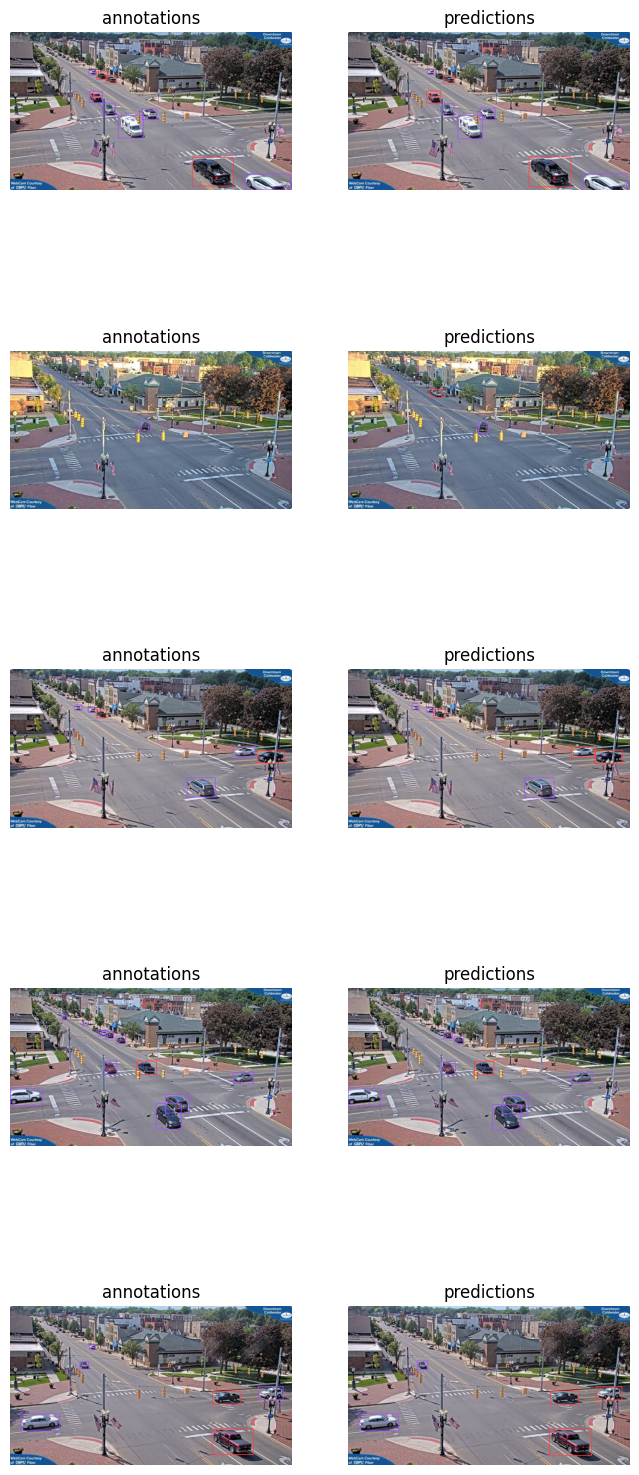

In [41]:
# Annotations vs original predictions on test images set

MAX_IMAGE_COUNT = 5

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
#keys = [key for key in keys if key in predictions]
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key]#,
        #skip_label=True
    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key]#,
        #skip_label=True
    )
    images.append(frame_with_predictions)
    titles.append('predictions')
    print(key)

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))

### We weep all testing images (anotations and predictions) in a folder named "inference"

In [43]:
os.makedirs('inference_results/images/', exist_ok=True)

In [44]:
ROOT_TEST = '/content/drive/MyDrive/TIC-YOLO/ColdwaterML/images/test/'
all_images = os.listdir(ROOT_TEST)

In [45]:
for image in tqdm(all_images, total=len(all_images)):
    image_path = os.path.join(ROOT_TEST, image)
    out = model.predict(image_path)
    out.save('inference_results/images')
    os.rename(
        'inference_results/images/pred_0.jpg',
        os.path.join('inference_results/images/', image)
    )

  0%|          | 0/165 [00:00<?, ?it/s]

[2024-07-21 19:14:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-07-21 19:14:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-07-21 19:14:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-07-21 19:14:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-07-21 19:14:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-07-21 19:14:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-07-21 19:14:13] INFO -

In [46]:
# View all the imagenes stored in the folder "inference"
plot(
    image_path='inference_results/images/',
    label_path='/content/drive/MyDrive/TIC-YOLO/ColdwaterML/labels/test/',
    num_samples=4,
)

Output hidden; open in https://colab.research.google.com to view.

### **Section 08.02.** Filtering

In [47]:
# Function to create a filtered .txt file with a given image path
def save_filtered_annotations(file_path, bboxes, labels, threshold=0.0020): #0.0034, 0.0025, 0.0020, 0.0017, 0.0018, 0.0019, 0.0020
    with open(file_path, 'w') as f:
        for bbox, label in zip(bboxes, labels):
            x_c, y_c, w, h = bbox
            if w * h > threshold:
                f.write(f"{label} {x_c} {y_c} {w} {h}\n")


#### **Section 08.02.01.** Original Predictions (before filtering)

In [53]:
# View Original Predictions
sets_bdd = ['train','val','test']
num_samples_sets = [0,0,10] # Set up the number of samples in each set (Train, Val, Test) you want to see

for k in range(len(sets_bdd)):
  image_path = "/content/drive/MyDrive/TIC-YOLO/ColdwaterML/images/" + sets_bdd[k]
  label_path = "/content/drive/MyDrive/TIC-YOLO/Annotations_vs_Predictions/Original_Predictions/" + sets_bdd[k]
  all_images = glob.glob(image_path+'/*')
  all_labels = glob.glob(label_path+'/*')
  all_images.sort()
  all_labels.sort()

  temp = list(zip(all_images, all_labels))
  #random.shuffle(temp)
  all_images, all_labels = zip(*temp)
  all_images, all_labels = list(all_images), list(all_labels)

  print(f'%%%%%%%%%%%%%%%%%%%%%% Conjunto: {sets_bdd[k]} %%%%%%%%%%%%%%%%')
  for i in range(num_samples_sets[k]):
          image_name = all_images[i].split(os.path.sep)[-1]
          image = cv2.imread(all_images[i])
          with open(all_labels[i], 'r') as f:
              bboxes = []
              labels = []
              label_lines = f.readlines()
              for label_line in label_lines:
                  label, x_c, y_c, w, h = label_line.split(' ')
                  x_c = float(x_c)
                  y_c = float(y_c)
                  w = float(w)
                  h = float(h)
                  bboxes.append([x_c, y_c, w, h])
                  labels.append(int(float(label)))
          result_image = plot_box(image, bboxes, labels)
          plt.figure(figsize=(8, 4))
          plt.imshow(image[:, :, ::-1])
          plt.axis('off')
          plt.show()
          print(image_name)

Output hidden; open in https://colab.research.google.com to view.

#### **Section 08.02.01.** Keeping New .txt Files

In [56]:
os.makedirs('/content/drive/MyDrive/TIC-YOLO/Annotations_vs_Predictions/Filtered_Predictions/', exist_ok=True)  # Create the directory "Filtered_Predictions" if it doesn't exist

# Bucle to create all the new filtered .txt files

sets_bdd = ['train','val','test']

for k in range(len(sets_bdd)):
  image_path = "/content/drive/MyDrive/TIC-YOLO/ColdwaterML/images/" + sets_bdd[k]
  label_path = "/content/drive/MyDrive/TIC-YOLO/Annotations_vs_Predictions/Original_Predictions/" + sets_bdd[k]
  all_images = glob.glob(image_path+'/*')
  all_labels = glob.glob(label_path+'/*')
  all_images.sort()
  all_labels.sort()

  temp = list(zip(all_images, all_labels))
  random.shuffle(temp)
  all_images, all_labels = zip(*temp)
  all_images, all_labels = list(all_images), list(all_labels)

  num_images = len(all_images)

  for i in range(num_images):
          image_name = all_images[i].split(os.path.sep)[-1]
          main_name = os.path.splitext(os.path.basename(image_name))[0]
          image = cv2.imread(all_images[i])
          label_path_N2 = label_path + '/' + main_name + '.txt'
          output_path = '/content/drive/MyDrive/TIC-YOLO/Annotations_vs_Predictions/Filtered_Predictions/filtered_' + main_name + '.txt'

          bboxes = []
          labels = []
          with open(label_path_N2, 'r') as f:
              label_lines = f.readlines()
              for label_line in label_lines:
                  label_line = label_line.strip()
                  if not label_line:
                      continue
                  label, x_c, y_c, w, h = label_line.split(' ')
                  x_c = float(x_c)
                  y_c = float(y_c)
                  w = float(w)
                  h = float(h)
                  bboxes.append([x_c, y_c, w, h])
                  labels.append(label)

          save_filtered_annotations(output_path, bboxes, labels)


In [57]:
# This help to check if all files were kept
files = os.listdir('/content/drive/MyDrive/TIC-YOLO/Annotations_vs_Predictions/Filtered_Predictions')
len(files)

1155

#### **Section 08.02.03.** Testing Umbrals for Filtering
Observation: The threshold parameter of the save_filtered_annotations function found at the beginning of section 08.02 must be modified until you find a good threshold. Every time you make modifications to the function save_filtered_annotations, you have to execute the code written in section 08.02.1 in order to save the new txt files with the new filtered bounding boxes.

In [67]:
# Testing umbrals to filter again

#sets_bdd = ['train','val','test']
#num_samples_sets = [5,5,5]
sets_bdd = ['test']
num_samples_sets = [10]


for k in range(len(sets_bdd)):
  image_path = "/content/drive/MyDrive/TIC-YOLO/ColdwaterML/images/" + sets_bdd[k]
  label_path = "/content/drive/MyDrive/TIC-YOLO/Annotations_vs_Predictions/Filtered_Predictions"

  all_images = glob.glob(image_path+'/*')
  all_labels = glob.glob(label_path+'/*')
  #image_names = [all_images[j].split(os.path.sep)[-1] for j in all_labels]
  #all_labels = [all_labels_k for all_labels_k in all_labels if all_labels_k.split(os.path.sep)[-1][:1] == "6"]
  all_labels = [all_labels_k for all_labels_k in all_labels if all_labels_k.split(os.path.sep)[-1][:10] == "filtered_7"]

  all_images.sort()
  all_labels.sort()

  temp = list(zip(all_images, all_labels))
  #random.shuffle(temp)
  all_images, all_labels = zip(*temp)
  all_images, all_labels = list(all_images), list(all_labels)

  print(f'%%%%%%%%%%%%%%%%%%%%%% Conjunto: {sets_bdd[k]} %%%%%%%%%%%%%%%%')
  for i in range(num_samples_sets[k]):
          image_name = all_images[i].split(os.path.sep)[-1]
          image = cv2.imread(all_images[i])
          with open(all_labels[i], 'r') as f:
              bboxes = []
              labels = []
              label_lines = f.readlines()
              for label_line in label_lines:
                  label, x_c, y_c, w, h = label_line.split(' ')
                  x_c = float(x_c)
                  y_c = float(y_c)
                  w = float(w)
                  h = float(h)
                  bboxes.append([x_c, y_c, w, h])
                  labels.append(int(float(label)))
          result_image = plot_box(image, bboxes, labels)
          plt.figure(figsize=(10, 6))
          plt.imshow(image[:, :, ::-1])
          plt.axis('off')
          plt.show()
          print(image_name)

Output hidden; open in https://colab.research.google.com to view.

In [69]:
files = os.listdir('/content/drive/MyDrive/TIC-YOLO/Annotations_vs_Predictions/Filtered_Predictions/')
len(files)

1155